In [23]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

In [7]:
data = pd.read_csv("diabetes.csv")

In [8]:
##Redundant Features
cols = ['id', 'encounter_id', 'patient_nbr','payer_code']
data[cols]

,id,encounter_id,patient_nbr,payer_code
0,1,2278392,8222157,?
1,2,149190,55629189,?
2,3,64410,86047875,?
3,4,500364,82442376,?
4,5,16680,42519267,?
...,...,...,...,...
101761,101762,443847548,100162476,MC
101762,101763,443847782,74694222,MC
101763,101764,443854148,41088789,MC
101764,101765,443857166,31693671,MC


In [9]:
data = data.drop(columns = cols)

In [10]:
#data = data.replace("?", np.nan)

In [11]:
missing = data.isna().sum()
print("Features with Missing Values")
100 * missing[missing>0]/data.shape[0]

Features with Missing Values


max_glu_serum    94.746772
A1Cresult        83.277322
dtype: float64

In [12]:
data['readmitted'] = data['readmitted'].apply(lambda x : 0 if (x == '>30' or x == 'NO') else 1)

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [14]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
from tqdm import tqdm

In [27]:
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate

def BasedLine(df, method, models, n_splits=10):
    start_time = time.time()  # Record the start time

    df_check = df.copy()

    y = df_check['readmitted']
    X = df_check.drop(columns='readmitted')

    X = X.fillna(0)

    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=2023, shuffle=True)

    scoring = 'accuracy'
    results, results_weigh = [], []
    names = []
    scores, scores_weigh = [], []
    auc_scores = []  # Store AUC scores
    data = []
    for name, model in models:
        model_scores = []
        model_scores_weigh = []
        model_auc_scores = []  # Store AUC scores for each fold

        with tqdm(total=n_splits, desc=f"Running {name}") as pbar:
            for train_idx, test_idx in stratified_kfold.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                score_non = f1_score(model.predict(X_valid), y_valid)
                score_weigh = f1_score(model.predict(X_valid), y_valid, average='weighted')
                model_scores.append(score_non)
                model_scores_weigh.append(score_weigh)

                # Calculate AUC score
                proba = model.predict_proba(X_valid)[:, 1]
                auc = roc_auc_score(y_valid, proba)
                model_auc_scores.append(auc)

                pbar.update(1)

        names.append(name)
        scores_weigh.append(model_scores_weigh)
        auc_scores.append(model_auc_scores)  # Store AUC scores for the model

        # Calculate mean AUC score across folds
        mean_auc = np.mean(model_auc_scores)

        data.append([name, np.mean(model_scores), np.mean(model_scores_weigh), mean_auc])

    headers = ["Model", "F1 Score", "F1 Score Weighted", "AUC Score"]
    print(tabulate(data, headers=headers, tablefmt='orgtbl'))

    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(execution_time))

    df_results = pd.DataFrame(data, columns=headers)
    return df_results


In [28]:
def BasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('GBM'  , GradientBoostingClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    basedModels.append(('XG'   , XGBClassifier()))
    basedModels.append(('LG'   , LGBMClassifier()))
    basedModels.append(('CAT'   , CatBoostClassifier(silent=True)))
    return basedModels

In [29]:
models = BasedModel()

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
#result
result = BasedLine(df = data, method = False , models = models, n_splits=10)

Running LR:   0%|                                                                               | 0/10 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Running LR:  10%|███████                                                                | 1/10 [00:02<00:22,  2.56s/it]C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  10%|███████                                                                | 1/10 [00:01<00:14,  1.63s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1190
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  20%|██████████████▏                                                        | 2/10 [00:03<00:13,  1.63s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1189
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  30%|█████████████████████▎                                                 | 3/10 [00:04<00:10,  1.56s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  40%|████████████████████████████▍                                          | 4/10 [00:06<00:09,  1.52s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1187
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  50%|███████████████████████████████████▌                                   | 5/10 [00:07<00:07,  1.52s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 91589, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111596 -> initscore=-2.074538
[LightGBM] [Info] Start training from score -2.074538


Running LG:  60%|██████████████████████████████████████████▌                            | 6/10 [00:09<00:06,  1.70s/it]

[LightGBM] [Info] Number of positive: 10222, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111606 -> initscore=-2.074440
[LightGBM] [Info] Start training from score -2.074440


Running LG:  70%|█████████████████████████████████████████████████▋                     | 7/10 [00:11<00:04,  1.63s/it]

[LightGBM] [Info] Number of positive: 10222, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111606 -> initscore=-2.074440
[LightGBM] [Info] Start training from score -2.074440


Running LG:  80%|████████████████████████████████████████████████████████▊              | 8/10 [00:12<00:03,  1.60s/it]

[LightGBM] [Info] Number of positive: 10222, number of negative: 81368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1183
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111606 -> initscore=-2.074440
[LightGBM] [Info] Start training from score -2.074440


Running LG:  90%|███████████████████████████████████████████████████████████████▉       | 9/10 [00:14<00:01,  1.57s/it]

[LightGBM] [Info] Number of positive: 10221, number of negative: 81369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 91590, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111595 -> initscore=-2.074550
[LightGBM] [Info] Start training from score -2.074550


Running CAT: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [07:42<00:00, 46.21s/it]

| Model   |   F1 Score |   F1 Score Weighted |   AUC Score |
|---------+------------+---------------------+-------------|
| LR      |  0.0284885 |            0.937594 |    0.597075 |
| RF      |  0.0181882 |            0.939388 |    0.644467 |
| GBM     |  0.0237372 |            0.93858  |    0.674505 |
| ET      |  0.0185109 |            0.939117 |    0.637558 |
| XG      |  0.0617671 |            0.933302 |    0.667959 |
| LG      |  0.0267755 |            0.938325 |    0.680488 |
| CAT     |  0.0449688 |            0.936326 |    0.680205 |
Execution time: 3060.34 seconds


In [34]:
result

,Model,F1 Score,F1 Score Weighted,AUC Score
0,LR,0.028488,0.937594,0.597075
1,RF,0.018188,0.939388,0.644467
2,GBM,0.023737,0.938580,0.674505
3,ET,0.018511,0.939117,0.637558
4,XG,0.061767,0.933302,0.667959
5,LG,0.026776,0.938325,0.680488
6,CAT,0.044969,0.936326,0.680205


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for color palettes

def plot_bar_and_histogram(dataframe):
    plt.figure(figsize=(15, 5))

    # Define a color palette with the number of unique models in the DataFrame
    num_models = len(dataframe['Model'])
    colors = sns.color_palette('husl', n_colors=num_models)

    # Bar plot for F1 Score
    ax1 = plt.subplot(1, 3, 1)
    bars = plt.bar(dataframe['Model'], dataframe['F1 Score'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('Plot of F1 Score')

    # Add text annotations to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

    # Bar plot for F1 Score Weighted
    plt.subplot(1, 3, 2)
    barss = plt.bar(dataframe['Model'], dataframe['F1 Score Weighted'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score Weighted')
    plt.title('Plot of F1 Score Weighted')

    # Add text annotations to the bars
    for bar in barss:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')
        
    # Bar plot for AUC Score
    plt.subplot(1, 3, 3)
    barss = plt.bar(dataframe['Model'], dataframe['AUC Score'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('AUC Score')
    plt.title('Plot of AUC Score')

    # Add text annotations to the bars
    for bar in barss:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


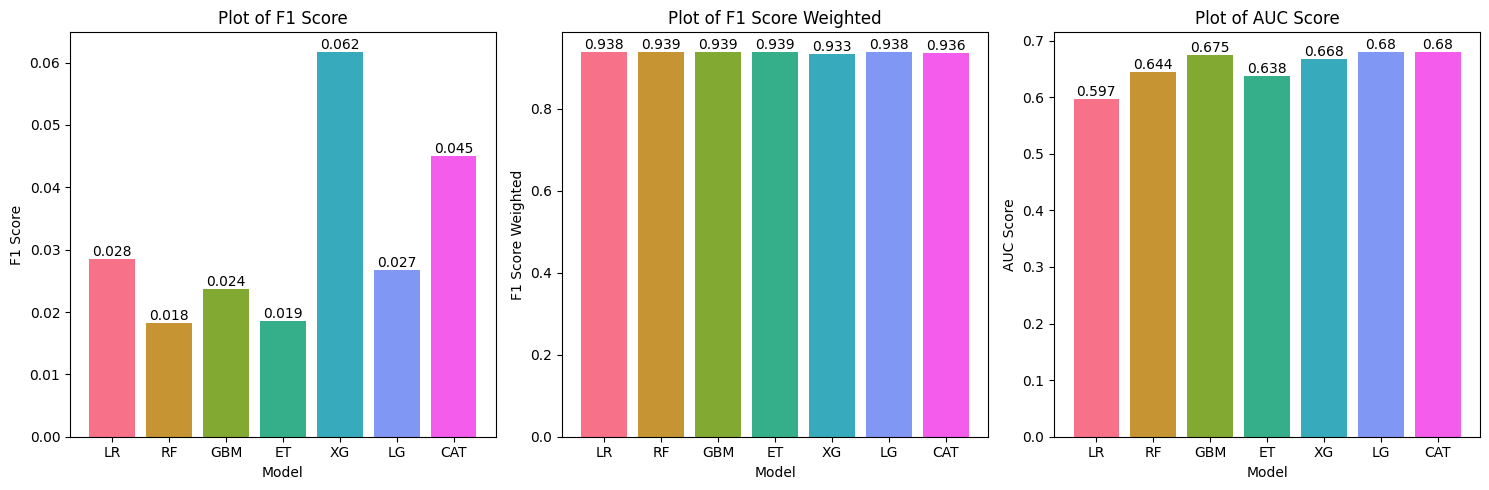

In [55]:
plot_bar_and_histogram(dataframe = result)